In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # read h5 file
import torch 
import h5py
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
# ## Read the meta_la data
data_path = 'DCRNN-master/data/METR-LA/df_highway_2012_4mon_sample.h5'
h5 = h5py.File(data_path, 'r')
data = h5['df']
speeds = data['block0_values'][:]

test1 = data['block0_values']
test1

<HDF5 dataset "block0_values": shape (34272, 207), type "<f8">

In [3]:
speeds = pd.DataFrame(speeds)
# speeds

In [4]:
# ## Extract one node for all time
node = speeds[0]
records = node.values.reshape(96, -1)

one_day = records[:,0]
x = np.arange(records.shape[0])

one_day2 = records[:, 1]

# speed_values = pd.Series(speeds.values.flatten())
# sns_plot = sns.distplot(speed_values, bins=100)
# fig = sns_plot.get_figure()
# fig.savefig('Statistic of META-LA overall')


In [5]:
df = pd.DataFrame()
records = records.T
day_count = 1
res = []
for day in range(records.shape[0]):
    for times in range(96):
        record = (day + 1, times, records[day][times])
        res.append(record)
df = pd.DataFrame(res, columns=['Day', 'Time step', 'Speed'])

In [6]:
# sns_plot2 = sns.relplot(
#     data=df,
#     x='Time step', y='Speed', kind='line')
# sns_plot2.savefig('For a day overall')

In [17]:
# Try to use the RNN for prediction
import torch 
from torch import nn

# Hyperparameter
TIME_STEP = 48 # predict 15min, 30min, 45min and 1h
INPUT_SIZE = 1
LR = 0.02

In [18]:
# Define the model
class RNN(nn.Module):
    def __init__(self, INPUT_SIZE):
        super(RNN, self).__init__()
        
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,
            num_layers=1,
            batch_first=True
        )
        
        self.out = nn.Linear(32, 1)
        
    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)
        
        outs = []
        for time in range(r_out.size(1)):
            outs.append(self.out(r_out[:, time, :]))
        return torch.stack(outs, dim=1), h_state

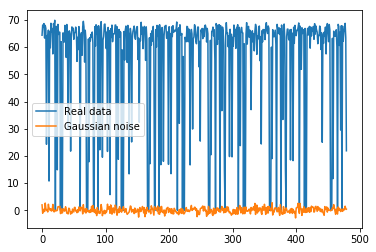

In [19]:
# generate data
TRAIN_DAY = 5
TRAIN_STEP = 96 * TRAIN_DAY

x_np = records[0:TRAIN_DAY,:].flatten()
plt.plot(np.arange(len(x_np)), x_np)
y_np = np.random.randn(TRAIN_STEP)
plt.plot(np.arange(TRAIN_STEP), y_np)
plt.legend(['Real data', 'Gaussian noise'], loc='best')
plt.savefig('Real data Vs Gaussian noise')

In [20]:
# train the model
model = RNN(INPUT_SIZE)
print(model)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [21]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [22]:
h_state = None

In [23]:
losses = []
for step in range(100, 400):
    start, end = step, step + TIME_STEP
    
#     steps = np.linspace(start, end, TIME_STEP, dtype=np.float32, endpoint=False)
    
#     x_np = np.sin(steps * np.pi)
#     y_np = np.cos(steps * np.pi)

    x_n = x_np[start: end].astype(np.float32)
    y_n = x_np[start - 96: end - 96].astype(np.float32) # use one day ahead for predicting
    
    x = torch.from_numpy(x_n[np.newaxis, :, np.newaxis])
    y = torch.from_numpy(y_n[np.newaxis, :, np.newaxis])
    
    prediction, h_state = model(x, h_state)
    h_state = h_state.data
    
    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Step {step - 100} | Loss = {loss}')
    losses.append(loss)

Step 0 | Loss = 3509.01171875
Step 1 | Loss = 3367.650634765625
Step 2 | Loss = 3268.565673828125
Step 3 | Loss = 3187.7548828125
Step 4 | Loss = 3174.1494140625
Step 5 | Loss = 3115.131591796875
Step 6 | Loss = 3048.293212890625
Step 7 | Loss = 2991.156494140625
Step 8 | Loss = 2990.485107421875
Step 9 | Loss = 2857.354248046875
Step 10 | Loss = 2806.58203125
Step 11 | Loss = 2736.800537109375
Step 12 | Loss = 2657.697021484375
Step 13 | Loss = 2599.80419921875
Step 14 | Loss = 2567.7001953125
Step 15 | Loss = 2505.953857421875
Step 16 | Loss = 2421.68359375
Step 17 | Loss = 2356.365478515625
Step 18 | Loss = 2354.247314453125
Step 19 | Loss = 2235.39404296875
Step 20 | Loss = 2122.423583984375
Step 21 | Loss = 2071.43798828125
Step 22 | Loss = 2008.8680419921875
Step 23 | Loss = 1908.0728759765625
Step 24 | Loss = 1856.2882080078125
Step 25 | Loss = 1803.5665283203125
Step 26 | Loss = 1805.2099609375
Step 27 | Loss = 1762.6895751953125
Step 28 | Loss = 1764.3953857421875
Step 29 | Lo

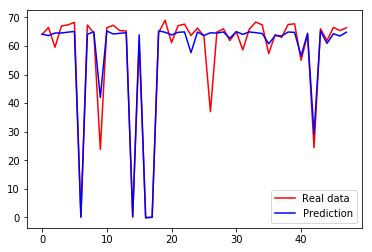

In [25]:
 # plotting
plt.plot(np.arange(TIME_STEP), y_n.flatten(), 'r-')
plt.plot(np.arange(TIME_STEP), prediction.data.numpy().flatten(), 'b-')
plt.legend(['Real data', 'Prediction'], loc='best')
plt.savefig('rnn prediction')
plt.draw();

In [28]:
abs_errors = []
square_errors = []
error_percentages = []
rmse= []
for add in range(50):
    index_start = add + 340
    real_value = x_np[index_start: index_start + TIME_STEP]
#     print(real_value)
    one_day_ago = x_np[index_start - 96: index_start + TIME_STEP - 96]
    prediction, _ = model(x, h_state) # always use the state
    prediction = prediction.data.numpy().flatten()
    # predict 15 min accuracy
    abs_error = np.absolute(real_value[0] - prediction[0])
    square_error = (real_value[0] - prediction[0]) ** 2
    error_percentage = abs_error / real_value[0] if real_value[0] != 0 else abs_error
    
    abs_errors.append(abs_error)
    square_errors.append(square_error)
    error_percentages.append(error_percentage)
    rmse.append(square_error ** 0.5)
    

    
print(f'MAE = {np.array(abs_errors).mean()}')
print(f'MSE = {np.array(square_errors).mean()}')
print(f'RMSE = {np.array(rmse).mean()}')
print(f'MAPE = {np.array(error_percentages).mean() * 100}%')

MAE = 12.80258720276848
MSE = 642.4386488905855
RMSE = 12.80258720276848
MAPE = 790.7183300940342%


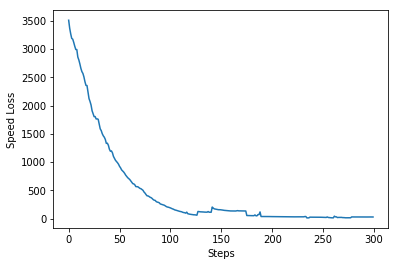

In [31]:

plt.plot(np.arange(len(losses)), losses)
plt.xlabel('Steps')
plt.ylabel('Speed Loss')
plt.savefig('rnn_train_loss')
plt.show()